In demo1, the processing time is longer than I expected. In this new demo, I start directly on resampled images for each CCD, and ignor the scale different between the original PSF and resampled PSF. 

I check one psacle = 1.0014158215291384, so I think this is negligible 

Then the stamp sources should be able to have a Null WCS, with PSF directly taken from the psfex file

I check how fast the code runs with this procedure

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
    
import sys
sys.path.append(".")

from FastObiwan import * 
import fitsio

In [2]:
brickname = '2383p305'

Obiwan_LRG = fitsio.read("/global/cfs/cdirs/desi/survey/catalogs/image_simulations/LRG/NGC/Obiwan_LRGs.fits", \
                         columns = ["brickname", "sim_gflux", "sim_rflux", "sim_zflux", \
                                    "sim_w1", "mw_transmission_w1", "sim_rhalf", "sim_e1", "sim_e2","sim_sersic_n",\
                                    'nobs_g', 'nobs_r', 'nobs_z', 'psfdepth_g', 'psfdepth_r', 'psfdepth_z','ra','dec', 'flux_r', 'flux_g', 'flux_z'])
Obiwan_LRG = Obiwan_LRG[Obiwan_LRG['brickname'] == brickname]
T = fits_table(Obiwan_LRG)
T.writeto("testbrick_2383p305.fits")

In [3]:
Obiwan_LRG = fitsio.read( "testbrick_2383p305.fits" )

In [4]:
Obiwan_Fast = LegacysurveyCCDList(brickname)
Obiwan_Fast.read_sim_gal( Obiwan_LRG ) 

In [5]:
Obiwan_Fast = LegacysurveyCCDList(brickname)
Obiwan_Fast.read_sim_gal( Obiwan_LRG ) 

catalog = []

import time
start_time = time.time()
L_sim = len(Obiwan_Fast.ra)

for i in range(L_sim):
    print(i)
    Obiwan_Fast.get_source(i, position = 'pixel')

    L_ccd = len(Obiwan_Fast.ccd_list)
    W,H = 31,31
    
    tims = []
    for j in range( L_ccd ): 
        
        Obiwan_Fast.init_one_ccd(j)
        flag, xx, yy = Obiwan_Fast.raw_twcs.radec2pixelxy( Obiwan_Fast.src_ra, Obiwan_Fast.src_dec )
        if xx<10 or xx>=Obiwan_Fast.ccd_width-10 or yy<10 or yy>=Obiwan_Fast.ccd_height-10:
            continue
        subpsf = Obiwan_Fast.raw_psf.constantPsfAt( xx-1, yy-1)
        photocal=LinearPhotoCal(1, band = Obiwan_Fast.filter)
        #print( Obiwan_Fast.filter)
        tim = Image( data = np.zeros((H,W)), invvar = np.ones((H,W)), psf = subpsf, wcs=NullWCS(), photocal = photocal)
        
        tractor_i = Tractor([tim], [Obiwan_Fast.source_i])
        clean_mod0 = tractor_i.getModelImage(0)
        
        final_data = clean_mod0+np.random.normal(size=clean_mod0.shape ) * Obiwan_Fast.sig1

        noise_stamp = clean_mod0/Obiwan_Fast.nano2e
        noise_stamp[np.where( noise_stamp < 0)] = 0
        assert( np.all(noise_stamp) >=0 )
        noise_sq_tot = np.ones((H,W))*Obiwan_Fast.sig1**2+noise_stamp
        final_invvar = 1./noise_sq_tot
        tim.data = final_data
        tim.setInvvar( final_invvar )
        #tim = Image( data = final_data, invvar = final_invvar, psf = subpsf, wcs=NullWCS(), photocal = photocal)
        
        tims.append(tim)

    guess_src = Obiwan_Fast.source_i.copy()
    guess_src.brightness.g = Obiwan_Fast.source_i.brightness.g*(1+np.random.normal()*0.05)
    guess_src.brightness.r = Obiwan_Fast.source_i.brightness.r*(1+np.random.normal()*0.05)
    guess_src.brightness.z = Obiwan_Fast.source_i.brightness.z*(1+np.random.normal()*0.05)
    if Obiwan_Fast.source_i.getSourceType() == 'SersicGalaxy':
        if Obiwan_Fast.source_i.sersicindex.val < 0.3:
            guess_src.sersicindex = LegacySersicIndex(0.3)
        if Obiwan_Fast.source_i.sersicindex.val > 5.3:
            guess_src.sersicindex = LegacySersicIndex(5.3)
    new_tractor = Tractor(tims, [guess_src])
    
    for i in range(50):
        dlnp,X,alpha = new_tractor.optimize()
        #print( 'dlnp', dlnp )
        if dlnp < 1e-5:
            break
    catalog.append(new_tractor.catalog[0])

end_time = time.time()
elapsed_time = end_time - start_time

# Convert to minutes
elapsed_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_minutes:.2f} minutes")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
Elapsed time: 6.67 minutes


In [174]:
new_tractor.catalog[0].brightness.r

0.7145170078628871

In [175]:
Obiwan_Fast.source_i.brightness.r

0.6787199

In [179]:
delta_r = []
for i in range( len(Obiwan_LRG)):
    delta_r.append( catalog[i].brightness.r - Obiwan_LRG['sim_rflux'][i] )
delta_r = np.array( delta_r)  

In [180]:
np.percentile( delta_r, 84) -   np.percentile( delta_r, 16)

0.10666592752318806

Text(0.5, 0, '$\\Delta flux\\, r$')

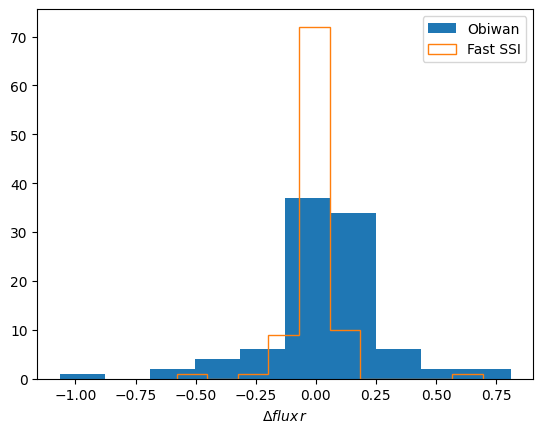

In [181]:
plt.hist( Obiwan_LRG['sim_rflux'] - Obiwan_LRG['flux_r'], label = 'Obiwan')
plt.hist( delta_r, histtype = 'step', label = 'Fast SSI' )
plt.legend()
plt.xlabel(r'$\Delta flux\, r$')